# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [148]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# import swifter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [65]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

# Load in the customer demographics data.
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

# azdias with all NaN as per feat_info
# azdias_with_all_null = pd.read_csv('azdias_with_all_null.csv')

# azdias_cleaned is the one after removing unwanted columns
# azdias_cleaned_cols = pd.read_csv('azdias_cleaned.csv')

# azdias_cleaned is the one after removing unwanted rows
#azdias_cleaned_rows = pd.read_csv('azdias_cleaned.csv')

# azdias_transformed is the one after feature engineering
#azdias_transformed = pd.read_csv('azdias_transformed.csv')

## Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).

In [3]:
len(azdias['CAMEO_INTL_2015'].unique())

23

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
display(feat_info.head(10))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Back up copy of orignal dataframe for later on comparison
azdias_copy = azdias.copy()

In [157]:
# Unique values count for each column 
for i in list(azdias):
    total = len(azdias[i])
    non_null = azdias[i].count()
    null_val = len(azdias[i]) - azdias[i].count()
    percent = round(((null_val/total) * 100), 2)
    
    print(f"Column Name: {i} \n \
    Total Rows: {total} \n \
    Non-Nulls: {non_null}  \n \
    Nulls : {null_val}  \n \
    % of Total: {percent} % \n \
    Unique values count: \n {azdias[i].value_counts()} \n")

'# Unique values count for each column \nfor i in list(azdias):\n    total = len(azdias[i])\n    non_null = azdias[i].count()\n    null_val = len(azdias[i]) - azdias[i].count()\n    percent = round(((null_val/total) * 100), 2)\n    \n    print(f"Column Name: {i} \n     Total Rows: {total} \n     Non-Nulls: {non_null}  \n     Nulls : {null_val}  \n     % of Total: {percent} % \n     Unique values count: \n {azdias[i].value_counts()} \n")'

In [10]:
before = azdias.isnull().sum().sum()
print(f'Over all naturally missing values in data frame azdias: {before}')

Over all naturally missing values in data frame azdias: 4896838


In [11]:
print(f'Naturally missing by each column: ')
display(azdias.isnull().sum())

Naturally missing by each column: 


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

Text(0, 0.5, 'Number of Null values')

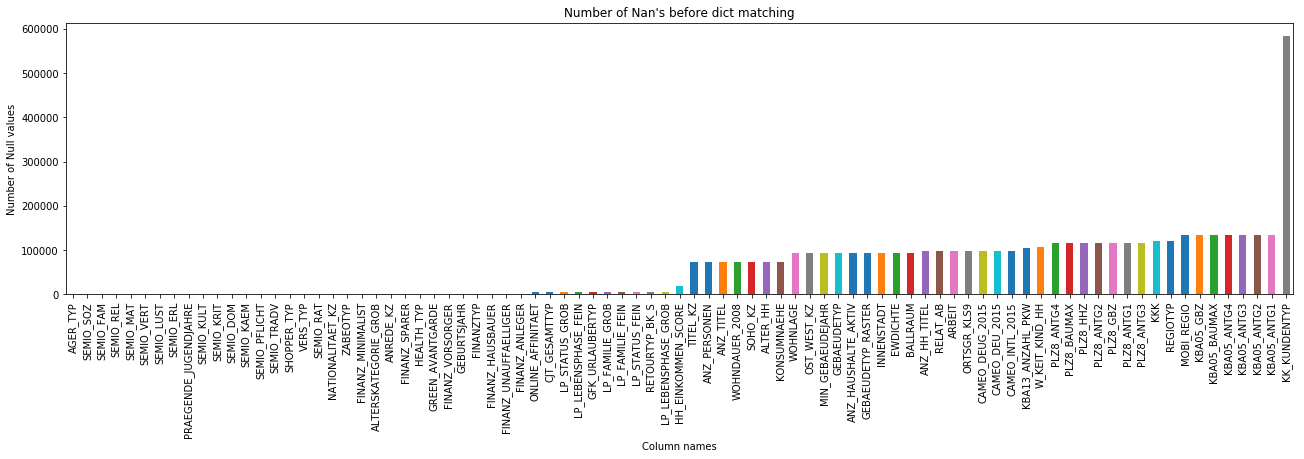

In [12]:
missing = azdias.isnull().sum()
missing.sort_values(inplace=True)
plt.figure(figsize=(22,5))
missing.plot.bar()
plt.title("Number of Nan's before dict matching")
plt.xlabel('Column names')
plt.ylabel('Number of Null values')

In [13]:
# Convert values to NaN by refrencing missing from data dict..

start = datetime.now()

for col in range(azdias.shape[1]):
    
    # If string not empty
    if (feat_info['missing_or_unknown'][col][1:-1]):
        
        # Create a new list with valid inputs (Numbers and characters) which will be used for matching
        check_list = list(feat_info['missing_or_unknown'][col][1:-1].split(','))
        check_list = [x if x in ['X', 'XX'] else int(x) for x in check_list]
        
        # Apply the lambda function to get NaN for values matching with check_list
        azdias.iloc[:, col] = azdias.iloc[:, col].apply(lambda x: np.nan if x in check_list else x)


print(f'Time taken: {(datetime.now() - start)}')

Time taken: 0:00:22.833263


In [ ]:
# Write to csv for later use or re-use
#azdias.to_csv('azdias_with_all_null.csv')

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

## Perform an assessment of how much missing data there is in each column of the dataset.

In [14]:
after = azdias.isnull().sum().sum()
print(f'Over all missing values in data frame azdias after dict matching: {after}')

Over all missing values in data frame azdias after dict matching: 8373929


In [15]:
diff = after - before
print(f'No of new NaN introduced: {diff}')

No of new NaN introduced: 3477091


Text(0, 0.5, 'Number of Null values')

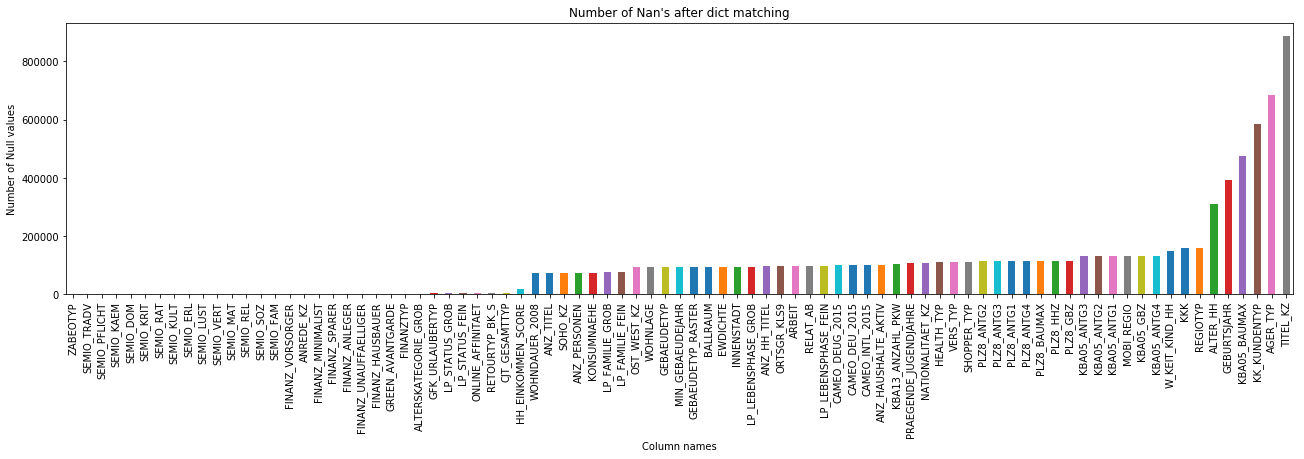

In [16]:
missing = azdias.isnull().sum()
missing.sort_values(inplace=True)
plt.figure(figsize=(22,5))
missing.plot.bar()
plt.title("Number of Nan's after dict matching")
plt.xlabel('Column names')
plt.ylabel('Number of Null values')

## Investigate patterns in the amount of missing data in each column.

In [17]:
# Counts and percentages before and after matching with Dict..

before_count = azdias_copy.isnull().sum()
before_percent = round((azdias_copy.isnull().sum() / len(azdias_copy)) * 100, 2)

after_count = azdias.isnull().sum()
after_percent = round((azdias.isnull().sum() / len(azdias)) * 100, 2)

percent_change = after_percent - before_percent

In [18]:
summary_df = pd.concat([before_count, before_percent, after_count, after_percent, percent_change], axis=1)
summary_df.columns = ['before_count', 'before_percent', 'after_count', 'after_percent', 'percent_change']
summary_df.sort_values(by=['after_percent'], ascending=False, inplace=True)
summary_df

,before_count,before_percent,after_count,after_percent,percent_change
TITEL_KZ,73499,8.25,889061,99.76,91.51
AGER_TYP,0,0.00,685843,76.96,76.96
KK_KUNDENTYP,584612,65.60,584612,65.60,0.00
KBA05_BAUMAX,133324,14.96,476524,53.47,38.51
GEBURTSJAHR,0,0.00,392318,44.02,44.02
ALTER_HH,73499,8.25,310267,34.81,26.56
KKK,121196,13.60,158064,17.74,4.14
REGIOTYP,121196,13.60,158064,17.74,4.14
W_KEIT_KIND_HH,107602,12.07,147988,16.61,4.54
KBA05_ANTG1,133324,14.96,133324,14.96,0.00


## Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)

Text(0, 0.5, 'Count')

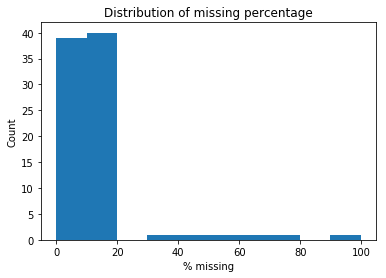

In [19]:
plt.hist(summary_df['after_percent'].values)
plt.title('Distribution of missing percentage')
plt.xlabel('% missing')
plt.ylabel('Count')

##  "We can clearly see most of the columns are below 20% missing and the outliers are more then 20%. We can removed them"

In [20]:
drop_list = summary_df[summary_df['after_percent'] >= 20]
drop_list

,before_count,before_percent,after_count,after_percent,percent_change
TITEL_KZ,73499,8.25,889061,99.76,91.51
AGER_TYP,0,0.00,685843,76.96,76.96
KK_KUNDENTYP,584612,65.60,584612,65.60,0.00
KBA05_BAUMAX,133324,14.96,476524,53.47,38.51
GEBURTSJAHR,0,0.00,392318,44.02,44.02
ALTER_HH,73499,8.25,310267,34.81,26.56


In [21]:
# New azdias after dropping cols
azdias_cleaned_cols = azdias.drop(drop_list.index, axis=1)
azdias_cleaned_cols.shape

(891221, 79)

In [ ]:
# Write to csv for further use azdias_cleaned_cols
#azdias_cleaned_cols.to_csv('azdias_cleaned_cols.csv')

In [22]:
drop_list.index

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [ ]:
# feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [23]:
# Drop same columns from the feat_info 

for col in drop_list.index:
    feat_info.drop(feat_info[feat_info['attribute'] == col].index, inplace = True)
    
feat_info.reset_index(inplace=True, drop= True)

# Discussion 1.1.2: Assess Missing Data in Each Column


'TITEL_KZ', 
'ANZ_TITEL', 
'ANZ_HH_TITEL', 
'GREEN_AVANTGARDE', 
'AGER_TYP',
'KK_KUNDENTYP', 
'KBA05_BAUMAX', 
'GEBURTSJAHR', 
'ALTER_HH' 

These columns have the most amount of missing values. Most of them lie in the group of more then 20% missing values.
Hence we decide to remove them from the final analysis and we will do the same for Udacity_CUSTOMERS_Subset.csv data set.


                before_count	before_percent	after_count	 after_percent	percent_change
    TITEL_KZ            73499	       8.25	          889061	       99.76	     91.51
    ANZ_TITEL	        73499	       8.25	          888041	       99.64	     91.39
    ANZ_HH_TITEL	    97008	      10.88	          867252	       97.31	     86.43
    GREEN_AVANTGARDE	   0	      0.00	          715996	       80.34	     80.34
    AGER_TYP	           0	      0.00	          685843	       76.96	     76.96
    KK_KUNDENTYP	    584612	      65.60	          584612	       65.60	      0.00
    KBA05_BAUMAX	    133324	      14.96	          476524	       53.47	     38.51
    GEBURTSJAHR	           0	      0.00	          392318	       44.02	     44.02
    ALTER_HH	         73499	      8.25	          310267	       34.81	     26.56

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# Left over columns summary
summary_leftover_cols = summary_df[summary_df['after_percent'] < 20]
# summary_leftover_cols

# cols_above_thresh = summary_leftover_cols[[summary_leftover_cols['after_percent'] > 5]]
# cols_below_thresh = summary_leftover_cols[[summary_leftover_cols['after_percent'] < 5]]

Text(0, 0.5, 'Count')

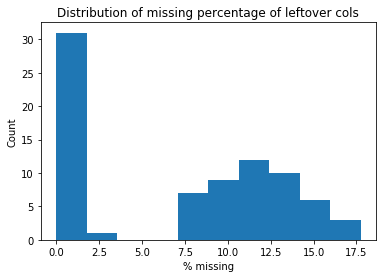

In [25]:
# Distribution of missing percentage of leftover cols
plt.hist(summary_leftover_cols['after_percent'].values)
plt.title('Distribution of missing percentage of leftover cols')
plt.xlabel('% missing')
plt.ylabel('Count')

In [26]:
# How much data is missing in each row of the left over dataset?
null_in_rows = azdias_cleaned_cols.T.isnull().sum()

Text(0, 0.5, 'Count')

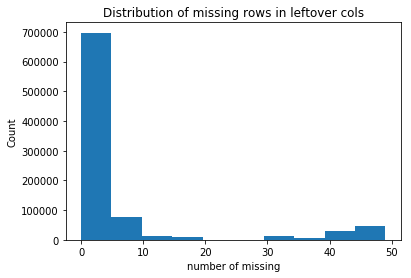

In [27]:
# Distribution of nulls in rows
plt.hist(null_in_rows)
plt.title('Distribution of missing rows in leftover cols')
plt.xlabel('number of missing')
plt.ylabel('Count')

In [28]:
# drop_list for rows indexes
condition = null_in_rows <= 20
drop_row_list = null_in_rows[condition == False]
drop_row_list_index = drop_row_list.index
drop_row_list_index

keep_row_list = null_in_rows[condition == True]
keep_row_list_index = keep_row_list.index

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#low_null_rows
azdias_low_null_rows = azdias_cleaned_cols.drop(drop_row_list_index, axis=0)
azdias_low_null_rows_percent = round((azdias_low_null_rows.shape[0] / azdias_cleaned_cols.shape[0]) * 100, 2)
#low_null_rows.reset_index

#high_null_rows
azdias_high_null_rows = azdias_cleaned_cols.drop(keep_row_list_index, axis=0)
azdias_high_null_rows_percent = round((azdias_high_null_rows.shape[0] / azdias_cleaned_cols.shape[0]) * 100, 2)

# Verify
azdias_low_null_rows.shape[0] + azdias_high_null_rows.shape[0] == azdias_cleaned_cols.shape[0]

print(f' Total number of records after column cleaning = {azdias_cleaned_cols.shape[0]} \n \
Count of records with low_nulls in rows = {azdias_low_null_rows.shape[0]} \t % of records = {azdias_low_null_rows_percent} \n \
Count of records with high_nulls in rows = {azdias_high_null_rows.shape[0]} \t % of records = {azdias_high_null_rows_percent} \n')

 Total number of records after column cleaning = 891221 
 Count of records with low_nulls in rows = 797426 	 % of records = 89.48 
 Count of records with high_nulls in rows = 93795 	 % of records = 10.52 



In [30]:
# Select the columns of interest
summary_leftover_cols.tail(35)

cols_of_interest = ['SEMIO_TRADV', 'SEMIO_SOZ', 'ALTERSKATEGORIE_GROB', 'HH_EINKOMMEN_SCORE', 'ONLINE_AFFINITAET']

/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/ravimalhotra/anaconda3/li

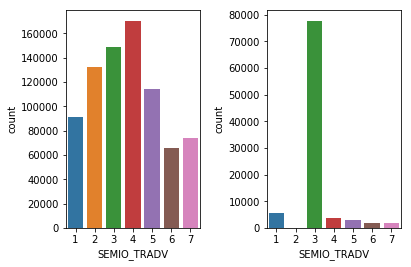

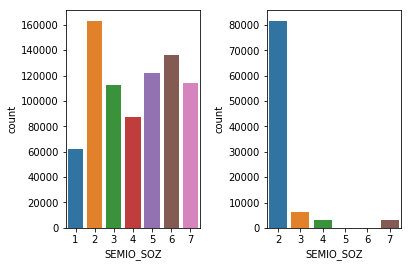

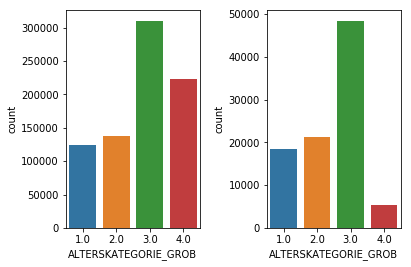

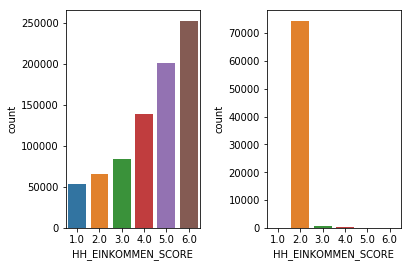

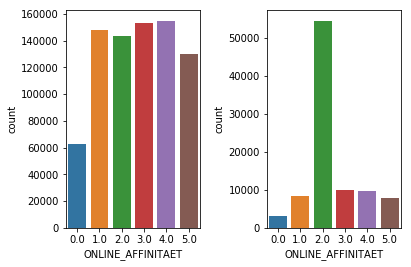

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_compare(df1, df2, column):
    fig, ax =plt.subplots(1,2)
    plt.subplots_adjust(wspace= 0.5)
    sns.countplot(df1[column], ax=ax[0])
    sns.countplot(df2[column], ax=ax[1])
    fig.show()
    return

for col in cols_of_interest:
    plot_compare(azdias_low_null_rows, azdias_high_null_rows, col)

In [32]:
# Drop highly sparce rows

# azdias_low_null_rows already contains rows with low number of nulls 
azdias_cleaned_rows = azdias_low_null_rows.copy()
azdias_cleaned_rows.reset_index(drop= True, inplace = True)

In [33]:
# Impute rest of the data set with most frequent value in the column

# Check azdias_cleaned_rows nan before operation
print(f"Numer of Nan's in data set before = {azdias_cleaned_rows.isnull().sum().sum()} \n")

# Log start time
start_time = datetime.now()

for col in list(azdias_cleaned_rows):
    azdias_cleaned_rows[col] = azdias_cleaned_rows[col].fillna(azdias_cleaned_rows[col].mode()[0])

Numer of Nan's in data set before = 999462 



In [34]:
# Check azdias_cleaned_rows
print(f"Numer of Nan's in data set = {azdias_cleaned_rows.isnull().sum().sum()} \n")

# Total time to execute
print(f'Total time to execute = {datetime.now() - start_time}')

# Write to csv
#azdias_cleaned_rows.to_csv('azdias_cleaned_rows.csv')

Numer of Nan's in data set = 0 

Total time to execute = 0:00:08.337025


#### Discussion 1.1.3: Assess Missing Data in Each Row

###### Here we see some patterns in data like:- missing of some particular attribute in a feature or very high values for some attribute. We can remove thses but it migh keep some bias for example: 

HH_EINKOMMEN_SCORE
Estimated household net income
for level 2: very high income --> The value is mainly in the subset with lost of missing rows. So if we plan to remove it then our data will be bias and we wont capture trates of these income groups.
Similarly this can be seen for all other columns and then can decided as per domain.


###### But for now it will be better to remove these very sparce rows from the data set and if required we can keep them and compare results.


Total number of records after column cleaning = 891221

Count of records with low_nulls in rows = 797317 ; 	 % of records = 89.46 

Count of records with high_nulls in rows = 93904 ;	 % of records = 10.54 

###### And we will impute rest of the columns with the most frequent value. We can do the same for above given 10.54 % in the end to to compare the results

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [35]:
# How many features are there of each data type?
# Investigation of columns

data_types = azdias_cleaned_rows.dtypes.value_counts()

for index in data_types.index:
    print(f'Total number of features with {index} = {data_types[index]}')
    
object_type_cols = []

for val in azdias_cleaned_rows.dtypes.index:
    if azdias_cleaned_rows.dtypes[val] == "object":
        object_type_cols.append(val)

Total number of features with float64 = 51
Total number of features with int64 = 24
Total number of features with object = 4


In [36]:
# Object type columns
print(f'Ordinal cols = {object_type_cols}')

Ordinal cols = ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']


In [37]:
# Display details of object type columns
for col in object_type_cols:
    print(f'Col name: {col} \n \
    {azdias_cleaned_rows[col].value_counts()} \n')

Col name: OST_WEST_KZ 
     W    628987
O    168439
Name: OST_WEST_KZ, dtype: int64 

Col name: CAMEO_DEUG_2015 
     8    140411
9    108152
6    105840
4    103842
3     86666
2     83174
7     77904
5     55249
1     36188
Name: CAMEO_DEUG_2015, dtype: int64 

Col name: CAMEO_DEU_2015 
     6B    62656
8A    52430
4C    47779
2D    35059
3C    34753
7A    34389
3D    34285
8B    33427
4A    33137
8C    30983
9D    28592
9B    27665
9C    24986
7B    24493
9A    20538
2C    19412
8D    17568
6E    16105
2B    15469
5D    14937
6C    14817
2A    13234
5A    12177
1D    11908
1A    10842
3A    10483
5B    10346
5C     9928
7C     9062
4B     9039
4D     8567
3B     7145
6A     6802
9E     6371
6D     6071
6F     5392
7D     5331
4E     5320
1E     5058
7E     4629
1C     4312
5F     4281
1B     4068
5E     3580
Name: CAMEO_DEU_2015, dtype: int64 

Col name: CAMEO_INTL_2015 
     51    139676
41     92309
24     91099
14     62851
43     56653
54     45376
25     39605
22     33137
23  

#### We can see that 2 object columns have numbers as string in the rows. This is the reason 2 columns 
#### "CAMEO_DEUG_2015" and "CAMEO_INTL_2015" are in object type columns and for other 2 columns we need to re-encode values to numeric

In [38]:
# Check object column and check unique values are string or int or float

for col in object_type_cols:
    temp = list(set(azdias_cleaned_rows[col]))
    temp = [x for x in temp if not x != x]
    #temp = [x for x in temp if x is not np.nan]
    print(f' Column name = {col} \n Values = {temp} \n')

 Column name = OST_WEST_KZ 
 Values = ['O', 'W'] 

 Column name = CAMEO_DEUG_2015 
 Values = ['1', '5', '8', '3', '6', '4', '2', '7', '9'] 

 Column name = CAMEO_DEU_2015 
 Values = ['2D', '7C', '9D', '6A', '4A', '5C', '1D', '6C', '6D', '1A', '6E', '8A', '8B', '1C', '8C', '5E', '2A', '4C', '1B', '2C', '8D', '9B', '7E', '5F', '6F', '4E', '3B', '3D', '9C', '3A', '7A', '7D', '3C', '6B', '5A', '9E', '9A', '4D', '4B', '2B', '5B', '1E', '5D', '7B'] 

 Column name = CAMEO_INTL_2015 
 Values = ['55', '22', '31', '14', '41', '32', '44', '24', '25', '33', '51', '54', '23', '34', '52', '43', '45', '15', '12', '13', '35'] 



In [39]:
# Check non-object column and check unique values are string or int or float

temp = list(set(azdias_cleaned_rows["ZABEOTYP"]))
temp = [x for x in temp if not x != x]
#temp = [x for x in temp if x is not np.nan]
print(f'Column name = ZABEOTYP \nValues = {temp} \n')

Column name = ZABEOTYP 
Values = [1, 2, 3, 4, 5, 6] 



#### We will also check the data dict to get some details of these columns and will see how it is categorised as per data dict


In [40]:
feat_info.head(1)

,attribute,information_level,type,missing_or_unknown
0,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


In [41]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [42]:
# Display categorical cols as per dic. Here we can find 3 columns 
# 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'

feat_info[feat_info['type'] == "categorical"]

,attribute,information_level,type,missing_or_unknown
1,ANREDE_KZ,person,categorical,"[-1,0]"
2,CJT_GESAMTTYP,person,categorical,[0]
9,FINANZTYP,person,categorical,[-1]
10,GFK_URLAUBERTYP,person,categorical,[]
11,GREEN_AVANTGARDE,person,categorical,[]
15,LP_FAMILIE_FEIN,person,categorical,[0]
16,LP_FAMILIE_GROB,person,categorical,[0]
17,LP_STATUS_FEIN,person,categorical,[0]
18,LP_STATUS_GROB,person,categorical,[0]
19,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [43]:
# # Display mixed cols as per dic. Here we can find 1 columns 
# 'CAMEO_INTL_2015'

feat_info[feat_info['type'] == "mixed"]

,attribute,information_level,type,missing_or_unknown
13,LP_LEBENSPHASE_FEIN,person,mixed,[0]
14,LP_LEBENSPHASE_GROB,person,mixed,[0]
20,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
51,WOHNLAGE,building,mixed,[-1]
54,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
73,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [44]:
# Make a copy of azdias_cleaned_rows

azdias_transformed = azdias_cleaned_rows.copy()

Text(0, 0.5, 'no of features')

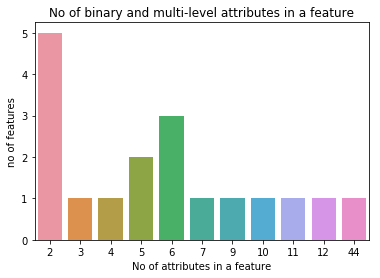

In [45]:
# Assess categorical variables: which are binary, which are multi-level

cat_col = feat_info[feat_info['type'] == "categorical"]['attribute'].values

columns = []
levels = []

for col in list(cat_col):
    columns.append(col)
    levels.append(len(azdias_transformed[col].value_counts().index))

cat_col_levels = pd.DataFrame([columns, levels]).T
cat_col_levels.columns = ["name", "count"]

sns.countplot(cat_col_levels['count'])
plt.title('No of binary and multi-level attributes in a feature')
plt.xlabel('No of attributes in a feature')
plt.ylabel('no of features')

In [46]:
# Re-encode categorical and mixed variable(s) with non numeric values to be kept in the analysis.

"""From previous analysis we know that we have 4 categorical columns that we need to re-encode the values as numbers
'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015' """

for col in ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']:
    
    # 2 columns with numeric strings
    if col in ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]:
        
        # Unique old values and sort them by Asc. order
        old = list(azdias_transformed[col].unique())
        old = [x for x in old if not x != x] # old = [x for x in old if np.isnan(x) == False]
        old.sort(key=float)
    else:
        # for columns with non-numeric strings
        # Unique old values and sort them by Asc. order
        old = list(azdias_transformed[col].unique())
        old = [x for x in old if not x != x] # old = [x for x in old if np.isnan(x) == False]
        old.sort()
        
    # Unique new values
    new = list(range(1, len(old) + 1))
    
    # Dict for keeping values and match
    check = dict(zip(old, new))
    
    # replace old values with new
    azdias_transformed[col] = azdias_transformed[col].apply(lambda x: check[x] if not x != x else x)

In [ ]:
# Check results
#for col in ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']:
#    temp = list(set(azdias_transformed[col]))
#    temp = [x for x in temp if x is not np.nan]
#    print(f' Column name = {col} \n Values = {temp} \n')"""

In [47]:
# We will remove features with high number of attributes. In our case we will only remove the one with 44 values
# or any thing above 12

# Find the features with attributes above 12
high_attributes = cat_col_levels[cat_col_levels['count'] > 12]['name'].values
high_attributes

# Drop from azdias_transformed
azdias_transformed.drop(azdias_transformed[high_attributes], axis=1, inplace=True)

# Also drop from feat_info
# Drop same columns from the feat_info 

for col in high_attributes:
    feat_info.drop(feat_info[feat_info['attribute'] == col].index, inplace = True)
    
feat_info.reset_index(inplace=True, drop= True)

In [48]:
# Copy of azdias_transformed 
azdias_onehot_transformed = azdias_transformed.copy()

In [49]:
feat_info[feat_info['type'] == "categorical"]['attribute'].values

array(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015'], dtype=object)

In [ ]:
#onehot_df = pd.get_dummies(azdias_onehot_transformed['GEBAEUDETYP'], prefix=(col))
#onehot_df.head()

In [50]:
# One hot encoding of categorical columns

for col in (feat_info[feat_info['type'] == "categorical"]['attribute'].values):
    onehot_df = pd.get_dummies(azdias_onehot_transformed[col], prefix=(col))
    azdias_onehot_transformed.drop(col, axis=1)
    azdias_onehot_transformed = azdias_onehot_transformed.join(onehot_df)

# Print list of new columns and shape of new df

print(f" Shape of new data frame = {azdias_onehot_transformed.shape}")
#        columns = \n {list(azdias_onehot_transformed)}")

 Shape of new data frame = (797426, 172)


#### Discussion 1.2.1: Re-Encode Categorical Features

After checking each feature's attributes we can see CAMEO_DEU_2015 was having very hign number of attributes which is 44, so we decided to drop the feature from our analysis and keep other for one_shot encoding.

Before this we also applied attributes re-encoding for features with string attributes or integers as strings.
our target group was 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'

In last we did the onehot encoding to get dummie variables of all categorical variables

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [51]:
# mixed type columns
mix_cols = feat_info[feat_info['type'] == "mixed"]
mix_cols

,attribute,information_level,type,missing_or_unknown
13,LP_LEBENSPHASE_FEIN,person,mixed,[0]
14,LP_LEBENSPHASE_GROB,person,mixed,[0]
20,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
51,WOHNLAGE,building,mixed,[-1]
53,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
72,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Get unique values from column with NaN's
values = list(azdias_onehot_transformed['PRAEGENDE_JUGENDJAHRE'].unique())
values = [x for x in values if not x != x]
values.sort()

# Derived columns encoding
youth = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
mainstream = ['Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde"]

# Dict for matching youth derived feature
dict_match = dict(zip(values, youth))

# Backup of column before re-encoding
backup_col = azdias_onehot_transformed['PRAEGENDE_JUGENDJAHRE'].copy()

# re-encode column for first feature youth
azdias_onehot_transformed['PRAEGENDE_JUGENDJAHRE'] = azdias_onehot_transformed['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: dict_match[x] if not x != x else x)

# Apply onehot encoding to get derived columns of youth
onehot_df = pd.get_dummies(azdias_onehot_transformed['PRAEGENDE_JUGENDJAHRE'], prefix=('PRAEGENDE_JUGENDJAHRE'))
azdias_onehot_transformed = azdias_onehot_transformed.join(onehot_df)

# Restore from backup 
azdias_onehot_transformed['PRAEGENDE_JUGENDJAHRE'] = backup_col

# Dict for matching mainstream derived feature 
dict_match = dict(zip(values, mainstream))

# re-encode column for first feature mainstream
azdias_onehot_transformed['PRAEGENDE_JUGENDJAHRE'] = azdias_onehot_transformed['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: dict_match[x] if not x != x else x)

# Apply onehot encoding to get derived columns of mainstream
onehot_df = pd.get_dummies(azdias_onehot_transformed['PRAEGENDE_JUGENDJAHRE'], prefix=('PRAEGENDE_JUGENDJAHRE'))
azdias_onehot_transformed = azdias_onehot_transformed.join(onehot_df)

# drop old columns
azdias_onehot_transformed.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [53]:
azdias_onehot_transformed.shape

(797426, 179)

In [54]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Get unique values from column with NaN's
values = list(azdias_onehot_transformed['CAMEO_INTL_2015'].unique())
values = [x for x in values ]
values.sort()

# Derived columns encoding
international_code = [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1]
wealth = ['Wealthy','Wealthy','Wealthy','Wealthy','Wealthy', 'Prosperous','Prosperous','Prosperous','Prosperous','Prosperous', 'Comfortable','Comfortable','Comfortable','Comfortable','Comfortable', "Less Affluent","Less Affluent","Less Affluent","Less Affluent","Less Affluent", "Poorer"]

# Dict for matching youth derived feature
dict_match = dict(zip(values, international_code))

# Backup of column before re-encoding
backup_col = azdias_onehot_transformed['CAMEO_INTL_2015'].copy()

# re-encode column for first feature international codes
azdias_onehot_transformed['CAMEO_INTL_2015'] = azdias_onehot_transformed['CAMEO_INTL_2015'].apply(lambda x: dict_match[x])

# Apply onehot encoding to get derived columns of youth
onehot_df = pd.get_dummies(azdias_onehot_transformed['CAMEO_INTL_2015'], prefix=('CAMEO_INTL_2015'))
azdias_onehot_transformed = azdias_onehot_transformed.join(onehot_df)

# Restore from backup 
azdias_onehot_transformed['CAMEO_INTL_2015'] = backup_col

# Dict for matching mainstream derived feature 
dict_match = dict(zip(values, wealth))

# re-encode column for first feature wealth
azdias_onehot_transformed['CAMEO_INTL_2015'] = azdias_onehot_transformed['CAMEO_INTL_2015'].apply(lambda x: dict_match[x])

# Apply onehot encoding to get derived columns of mainstream
onehot_df = pd.get_dummies(azdias_onehot_transformed['CAMEO_INTL_2015'], prefix=('CAMEO_INTL_2015'))
azdias_onehot_transformed = azdias_onehot_transformed.join(onehot_df)

# drop old columns
azdias_onehot_transformed.drop('CAMEO_INTL_2015', axis=1, inplace= True)

In [55]:
azdias_onehot_transformed.shape

(797426, 188)

In [56]:
# Drop same columns from the feat_info 

for col in ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE']:
    feat_info.drop(feat_info[feat_info['attribute'] == col].index, inplace = True)
    
feat_info.reset_index(inplace=True, drop= True)

In [57]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
13,LP_LEBENSPHASE_FEIN,person,mixed,[0]
14,LP_LEBENSPHASE_GROB,person,mixed,[0]
50,WOHNLAGE,building,mixed,[-1]
70,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [58]:
# One hot encoding of mixed columns

for col in (feat_info[feat_info['type'] == "mixed"]['attribute'].values):
    onehot_df = pd.get_dummies(azdias_onehot_transformed[col], prefix=(col))
    azdias_onehot_transformed.drop(col, axis=1, inplace=True)
    azdias_onehot_transformed = azdias_onehot_transformed.join(onehot_df)

# Print list of new columns and shape of new df

print(f" Shape of new data frame = {azdias_onehot_transformed.shape}")
#        columns = \n {list(azdias_onehot_transformed)}")

 Shape of new data frame = (797426, 253)


#### Discussion 1.2.2: Engineer Mixed-Type Features

only using 2 variables "PRAEGENDE_JUGENDJAHRE" , 'CAMEO_INTL_2015' for deriving new variables and rest of the mixed type will be onhot encoded. 

P_LEBENSPHASE_FEIN

LP_LEBENSPHASE_GROB

WOHNLAGE

PLZ8_BAUMAX

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [60]:
# Final check if all columns are type int or float
azdias_onehot_transformed.dtypes.value_counts()
print(f'No colums with type = object and nulls = {azdias_onehot_transformed.isnull().sum().sum()}')

No colums with type = object and nulls = 0


In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

##### Missing data is already handeled by imputing most frequent value in each column

In [ ]:
"""# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Cleaning function copy with step by step check

start_time = datetime.now()

# Status initail
print(f'Initial status \n')
initial_shape = df.shape
print(f'Shape = {initial_shape} \n')
before = df.isnull().sum().sum()
print(f'Over all naturally missing values in data frame: {before} \n')
data_types = df.dtypes.value_counts()
for index in data_types.index:
    print(f'Total number of features with {index} = {data_types[index]} \n')


#### Convert values to NaN by refrencing missing from data dict.. ####
#
for col in range(df.shape[1]):
    
    # If string not empty
    if (feat_info['missing_or_unknown'][col][1:-1]):
        
        # Create a new list with valid inputs (Numbers and characters) which will be used for matching
        check_list = list(feat_info['missing_or_unknown'][col][1:-1].split(','))
        check_list = [x if x in ['X', 'XX'] else int(x) for x in check_list]
        
        # Apply the lambda function to get NaN for values matching with check_list
        df.iloc[:, col] = df.iloc[:, col].apply(lambda x: np.nan if x in check_list else x)

# Status after getting all nulls
print(f'Status after gettting all nulls')
print(f'Shape = {df.shape} \n')
after = df.isnull().sum().sum()
print(f'Over all missing values in data frame after dict matching: {after} \n')



#### Drop unwanted columns ####
# unwanted columns list
drop_list = ['TITEL_KZ', 'ANZ_TITEL', 'ANZ_HH_TITEL', 'GREEN_AVANTGARDE', 'AGER_TYP',
       'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'CAMEO_DEU_2015']

# Drop unwanted columns from df
df = df.drop(drop_list, axis=1)

# Drop unwanted columns from feat_info
for col in drop_list:
    feat_info.drop(feat_info[feat_info['attribute'] == col].index, inplace = True)
feat_info.reset_index(inplace=True, drop= True)

# Status after deleting unwanted columns
print(f'Status after deleting unwanted columns')
print(f'Shape = {df.shape} \n')
after = df.isnull().sum().sum()
print(f'Over all missing values in data frame: {after} \n')



#### Remove rows with more then 20 nulls ####
# How much data is missing in each row of the left over dataset?
row_nulls = df.T.isnull().sum()

# Condition
condition = row_nulls <= 20
drop_list = row_nulls[condition == False].index
df = df.drop(drop_list, axis=0)
df.reset_index(drop= True, inplace = True)

# Status after deleting unwanted rows
print(f'Status after deleting unwanted rows')
print(f'Shape = {df.shape} \n')
after = df.isnull().sum().sum()
print(f'Over all missing values in data frame: {after} \n')


#### Impute rest of the data set with most frequent value in the column ####
#
for col in list(df):
    df[col] = df[col].fillna(df[col].mode()[0])

# Status after imputing nan's with Mode()
print(f'Status after imputing NaN with Mode()')
print(f'Shape = {df.shape} \n')
after = df.isnull().sum().sum()
print(f'Over all missing values in data frame: {after} \n')
data_types = df.dtypes.value_counts()
for index in data_types.index:
	print(f'Total number of features with {index} = {data_types[index]} \n')



#### Feature engineering ####
# Make 4 new cols from 2 cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
eng_col = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

for col in eng_col:

	# Get unique values from column
	values = list(df[col].unique())
	values = [x for x in values if not x != x]
	values.sort()

	# Derived columns encoding
	if col == 'PRAEGENDE_JUGENDJAHRE':
		a = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
		b = ['Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde"]
	else:
		a = [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1]
		b = ['Wealthy','Wealthy','Wealthy','Wealthy','Wealthy', 'Prosperous','Prosperous','Prosperous','Prosperous','Prosperous', 'Comfortable','Comfortable','Comfortable','Comfortable','Comfortable', "Less Affluent","Less Affluent","Less Affluent","Less Affluent","Less Affluent", "Poorer"]

	for new_feature in [a, b]:

		# Dict for matching youth derived feature
		dict_match = dict(zip(values, new_feature))

		# Backup of column before re-encoding
		backup_col = df[col].copy()

		# re-encode column for first feature youth
		df[col] = df[col].apply(lambda x: dict_match[x] if not x != x else x)

		# Apply onehot encoding to get derived columns of youth
		onehot_df = pd.get_dummies(df[col], prefix=(col))
		df = df.join(onehot_df)

		# Restore from backup 
		df[col] = backup_col

	# drop old columns
	df.drop(col, axis=1, inplace=True)

# Drop same columns from the feat_info 
for col in ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE']:
    feat_info.drop(feat_info[feat_info['attribute'] == col].index, inplace = True)
feat_info.reset_index(inplace=True, drop= True)

# Status after making 2 new derived variables
print(f'Status after imaking 2 new derived variables')
print(f'Shape = {df.shape} \n')
after = df.isnull().sum().sum()
print(f'Over all missing values in data frame: {after} \n')
data_types = df.dtypes.value_counts()
for index in data_types.index:
	print(f'Total number of features with {index} = {data_types[index]} \n')



#### Onehot encoding for categorical and mixed type ####
# One hot encoding 
mix_cat = list(feat_info[feat_info['type'] == "categorical"]['attribute'].values)  +  list(feat_info[feat_info['type'] == "mixed"]['attribute'].values)
for col in mix_cat:
    onehot_df = pd.get_dummies(df[col], prefix=(col))
    df.drop(col, axis=1, inplace=True)
    df = df.join(onehot_df)

# Status after onehot encoding for categorical and mixed type
print(f'Status after onehot encoding for categorical and mixed type')
final_shape = df.shape
print(f'Shape = {final_shape} \n')
after = df.isnull().sum().sum()
print(f'Over all missing values in data frame: {after} \n')
data_types = df.dtypes.value_counts()
for index in data_types.index:
    print(f'Total number of features with {index} = {data_types[index]} \n')
    
# Total records lossed and features increased after cleaning
print(f'Number of new features introduced = {final_shape[1] - initial_shape[1]} \n')
print(f'No of records lost { round(100 - (final_shape[0] / initial_shape[0]) * 100, 2)} + %')


# End time
end_time = datetime.now()
total_time = end_time - start_time
print(f'Total time to execute the function = {total_time}')
print(f'Time taken: {end_time - start_time} \n')"""

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [91]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    start_time = datetime.now()

    # Status initail
    print(f'Initial status \n')
    initial_shape = df.shape
    print(f'Shape = {initial_shape} \n')
    before = df.isnull().sum().sum()
    print(f'Over all naturally missing values in data frame: {before} \n')
    data_types = df.dtypes.value_counts()
    for index in data_types.index:
        print(f'Total number of features with {index} = {data_types[index]} \n')

    #### Convert values to NaN by refrencing missing from data dict.. ####
    for col in range(df.shape[1]):

        # If string not empty
        if (feat_info['missing_or_unknown'][col][1:-1]):

            # Create a new list with valid inputs (Numbers and characters) which will be used for matching
            check_list = list(feat_info['missing_or_unknown'][col][1:-1].split(','))
            check_list = [x if x in ['X', 'XX'] else int(x) for x in check_list]

            # Apply the lambda function to get NaN for values matching with check_list
            df.iloc[:, col] = df.iloc[:, col].apply(lambda x: np.nan if x in check_list else x)

    #### Drop unwanted columns ####
    # unwanted columns list
    drop_list = ['TITEL_KZ', 'ANZ_TITEL', 'ANZ_HH_TITEL', 'GREEN_AVANTGARDE', 'AGER_TYP',
           'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'CAMEO_DEU_2015']

    # Drop unwanted columns from df
    df = df.drop(drop_list, axis=1)

    # Drop unwanted columns from feat_info
    for col in drop_list:
        feat_info.drop(feat_info[feat_info['attribute'] == col].index, inplace = True)
    feat_info.reset_index(inplace=True, drop= True)

    #### Remove rows with more then 20 nulls ####
    # How much data is missing in each row of the left over dataset?
    row_nulls = df.T.isnull().sum()

    # Condition
    condition = row_nulls <= 20
    drop_list = row_nulls[condition == False].index
    df = df.drop(drop_list, axis=0)
    df.reset_index(drop= True, inplace = True)

    #### Impute rest of the data set with most frequent value in the column ####
    #
    for col in list(df):
        df[col] = df[col].fillna(df[col].mode()[0])

    #### Feature engineering ####
    # Make 4 new cols from 2 cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    eng_col = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

    for col in eng_col:

        # Get unique values from column
        values = list(df[col].unique())
        values = [x for x in values if not x != x]
        values.sort()

        # Derived columns encoding
        if col == 'PRAEGENDE_JUGENDJAHRE':
            a = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
            b = ['Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde", 'Mainstream', "Avantgarde"]
        else:
            a = [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1]
            b = ['Wealthy','Wealthy','Wealthy','Wealthy','Wealthy', 'Prosperous','Prosperous','Prosperous','Prosperous','Prosperous', 'Comfortable','Comfortable','Comfortable','Comfortable','Comfortable', "Less Affluent","Less Affluent","Less Affluent","Less Affluent","Less Affluent", "Poorer"]

        for new_feature in [a, b]:

            # Dict for matching youth derived feature
            dict_match = dict(zip(values, new_feature))

            # Backup of column before re-encoding
            backup_col = df[col].copy()

            # re-encode column for first feature youth
            df[col] = df[col].apply(lambda x: dict_match[x] if not x != x else x)

            # Apply onehot encoding to get derived columns of youth
            onehot_df = pd.get_dummies(df[col], prefix=(col))
            df = df.join(onehot_df)

            # Restore from backup 
            df[col] = backup_col

        # drop old columns
        df.drop(col, axis=1, inplace=True)

    # Drop same columns from the feat_info 
    for col in ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE']:
        feat_info.drop(feat_info[feat_info['attribute'] == col].index, inplace = True)
    feat_info.reset_index(inplace=True, drop= True)

    #### Onehot encoding for categorical and mixed type ####
    # One hot encoding 
    mix_cat = list(feat_info[feat_info['type'] == "categorical"]['attribute'].values)  +  list(feat_info[feat_info['type'] == "mixed"]['attribute'].values)
    for col in mix_cat:
        onehot_df = pd.get_dummies(df[col], prefix=(col))
        df.drop(col, axis=1, inplace=True)
        df = df.join(onehot_df)

    # Status after onehot encoding for categorical and mixed type
    print(f'Status after onehot encoding for categorical and mixed type')
    final_shape = df.shape
    print(f'Shape = {final_shape} \n')
    after = df.isnull().sum().sum()
    print(f'Over all missing values in data frame: {after} \n')
    data_types = df.dtypes.value_counts()
    for index in data_types.index:
        print(f'Total number of features with {index} = {data_types[index]} \n')
        
    # Total records lossed and features increased after cleaning
    print(f'Number of new features introduced = {final_shape[1] - initial_shape[1]} \n')
    print(f'No of records lost { round(100 - (final_shape[0] / initial_shape[0]) * 100, 2)} + %')

    # End time
    end_time = datetime.now()
    total_time = end_time - start_time
    print(f'Total time to execute the function = {total_time}')
    print(f'Time taken: {end_time - start_time} \n')
    
    return df

In [88]:
# Test on azdias data frame

# Duplicate df and re-load feat_info
azdias_dup = azdias.copy()
# Load in the feature summary file again. previous orignal one is trimmed
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

# Run function
azdias_cleaned = clean_data(azdias_dup)

Initial status 

Shape = (891221, 85) 

Over all naturally missing values in data frame: 4896838 

Total number of features with float64 = 49 

Total number of features with int64 = 32 

Total number of features with object = 4 

Status after onehot encoding for categorical and mixed type
Shape = (797470, 228) 

Over all missing values in data frame: 0 

Total number of features with uint8 = 175 

Total number of features with float64 = 33 

Total number of features with int64 = 20 

Number of new features introduced = 143 

No of records lost 10.52
Total time to execute the function = 0:01:05.936933
Time taken: 0:01:05.936933 



In [89]:
# Test on customer data frame

# Duplicate df and re-load feat_info
customer_dup = customer.copy()
# Load in the feature summary file again. previous orignal one is trimmed
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

# Run function
customer_cleaned = clean_data(customer_dup)

Initial status 

Shape = (191652, 85) 

Over all naturally missing values in data frame: 2252274 

Total number of features with float64 = 49 

Total number of features with int64 = 32 

Total number of features with object = 4 

Status after onehot encoding for categorical and mixed type
Shape = (141649, 227) 

Over all missing values in data frame: 0 

Total number of features with uint8 = 174 

Total number of features with float64 = 33 

Total number of features with int64 = 20 

Number of new features introduced = 142 

No of records lost 26.09
Total time to execute the function = 0:00:12.509414
Time taken: 0:00:12.509414 



In [90]:
# drop feature of azdias_cleaned not matching with customer_cleaned
drop_list =  [x for x in list(azdias_cleaned) if x not in list(customer_cleaned)]
drop_list

azdias_cleaned.drop(drop_list, axis=1, inplace= True)
azdias_cleaned.shape

(797470, 227)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

########. All done

In [93]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_cleaned)

# Convert nd array to data frame
azdias_scaled = pd.DataFrame(azdias_scaled)
azdias_scaled.columns = list(azdias_cleaned)
azdias_scaled.head()

/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,-1.766321,-1.494642,1.538218,-1.040713,1.466450,0.959636,1.338854,1.010368,-1.685022,0.442723,...,-0.674980,2.206271,-0.320548,-0.519096,-0.149351,0.725811,-0.311187,-0.260649,-0.27662,-0.372854
1,0.200596,-1.494642,0.864836,-1.766939,-0.570789,0.244924,1.338854,1.010368,-0.310528,-0.072476,...,-0.674980,-0.453253,-0.320548,-0.519096,-0.149351,0.725811,-0.311187,-0.260649,-0.27662,-0.372854
2,1.184054,0.683113,-0.481927,1.137963,-0.570789,-1.184500,-0.791952,-0.311669,-0.997775,0.442723,...,-0.674980,-0.453253,-0.320548,1.926427,-0.149351,0.725811,-0.311187,-0.260649,-0.27662,-0.372854
3,0.200596,0.683113,0.191454,0.411738,-1.249869,0.244924,-0.791952,1.010368,1.063965,0.957923,...,1.481525,-0.453253,-0.320548,-0.519096,-0.149351,-1.377769,3.213499,-0.260649,-0.27662,-0.372854
4,-1.766321,-0.042806,-1.155309,1.137963,-0.570789,-0.469788,1.338854,1.010368,-0.310528,-1.102876,...,-0.674980,-0.453253,-0.320548,1.926427,-0.149351,0.725811,-0.311187,-0.260649,-0.27662,-0.372854


### Discussion 2.1: Apply Feature Scaling

All the columns where handeled for missing values before applying Feature Scaling. This will bring the entire data to same scale which is required by PCA and also clustering tecniques.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [141]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

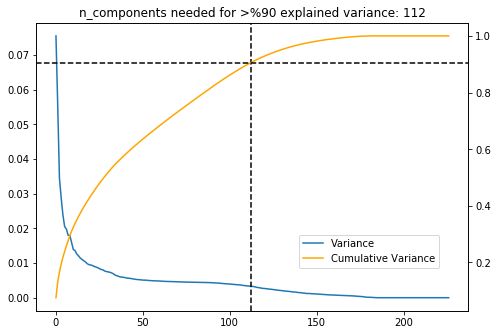

In [142]:
# Investigate the variance accounted for by each principal component.
# Number of components required to maintain %95 variance:
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.9)[0]+1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='Variance',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'orange');
ax.set_title('n_components needed for >%90 explained variance: {}'.format(n_components));
ax.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.6,0.2));

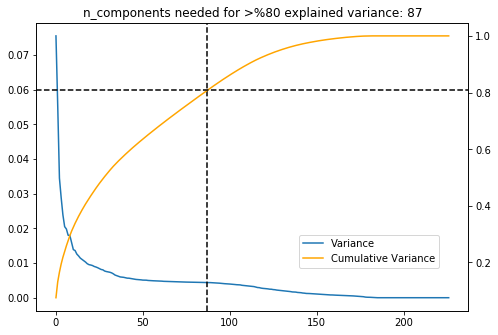

In [143]:
# Investigate the variance accounted for by each principal component.
# Number of components required to maintain %80 variance:
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0]+1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='Variance',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'orange');
ax.set_title('n_components needed for >%80 explained variance: {}'.format(n_components));
ax.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.6,0.2));

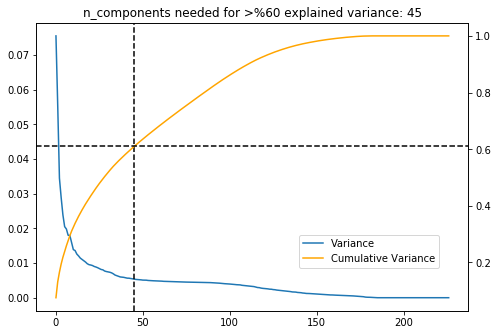

In [144]:
# Investigate the variance accounted for by each principal component.
# Number of components required to maintain %95 variance:
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.6)[0]+1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='Variance',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'orange');
ax.set_title('n_components needed for >%60 explained variance: {}'.format(n_components));
ax.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.6,0.2));

In [145]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=n_components, random_state=10)
azdias_pca = pca.fit_transform(azdias_scaled)

In [146]:
# Percentage of variance explained by the above graph
pca.explained_variance_ratio_.sum()

0.5996333364539264

### Discussion 2.2: Perform Dimensionality Reduction

After looking at varice explained at 90% , 60%, and 80% . i decide to go with 60% variance eplanation with 45 principle components

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [137]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def comp_analysis(azdias_cleaned):
    feature_map = pd.Series(azdias_cleaned.columns, range(len(azdias_cleaned.columns)))
    components = {}
    for ix in range(pca.components_.shape[0]):
        components[ix] = [(feature_map[a],b) for a,b in sorted(enumerate(pca.components_[ix]),key=lambda x:x[1],reverse=True)]
    return pd.DataFrame(components)

In [138]:
# Top 10 positive components
components = comp_analysis(azdias_cleaned)
components[:10]

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,"(LP_STATUS_GROB_1.0, 0.18727593901601322)","(ALTERSKATEGORIE_GROB, 0.21641347398279595)","(ANREDE_KZ_1, 0.3271413404481092)","(ANZ_PERSONEN, 0.22623174629634213)","(PRAEGENDE_JUGENDJAHRE_Mainstream, 0.243461089...","(LP_FAMILIE_GROB_4.0, 0.29142853982971595)","(LP_FAMILIE_FEIN_2.0, 0.4199649885397079)","(LP_STATUS_GROB_2.0, 0.316469111873747)","(LP_FAMILIE_GROB_3.0, 0.4464475909721701)","(LP_STATUS_GROB_3.0, 0.4381192096729214)",...,"(GEBAEUDETYP_6.0, 0.5398069070803702)","(GEBAEUDETYP_6.0, 0.3507371902680235)","(NATIONALITAET_KZ_3.0, 0.29072610344824346)","(LP_FAMILIE_FEIN_9.0, 0.29487464661214596)","(GEBAEUDETYP_4.0, 0.5003101925820633)","(LP_FAMILIE_FEIN_9.0, 0.3280601515651085)","(GFK_URLAUBERTYP_2.0, 0.23455793633200706)","(LP_FAMILIE_FEIN_7.0, 0.2624963405254125)","(GEBAEUDETYP_6.0, 0.2010785822339206)","(LP_LEBENSPHASE_FEIN_34.0, 0.2081477796315768)"
1,"(HH_EINKOMMEN_SCORE, 0.17270867887067248)","(FINANZ_VORSORGER, 0.2099699868875829)","(SEMIO_VERT, 0.2977441547080769)","(LP_FAMILIE_GROB_5.0, 0.2024121332521087)","(KKK, 0.17049439631153465)","(LP_LEBENSPHASE_GROB_8.0, 0.26672463294342097)","(LP_FAMILIE_GROB_2.0, 0.4199649885397079)","(LP_FAMILIE_GROB_4.0, 0.29545263477568484)","(LP_LEBENSPHASE_GROB_6.0, 0.4464475909721701)","(LP_STATUS_FEIN_6.0, 0.39359619940683743)",...,"(GEBAEUDETYP_4.0, 0.3113029608294694)","(LP_LEBENSPHASE_FEIN_35.0, 0.21017285872387947)","(GEBAEUDETYP_6.0, 0.2569780253962064)","(LP_LEBENSPHASE_FEIN_37.0, 0.2816235095182178)","(GFK_URLAUBERTYP_1.0, 0.2744951795324268)","(GFK_URLAUBERTYP_2.0, 0.23877979495664634)","(GEBAEUDETYP_6.0, 0.17068334179167347)","(LP_LEBENSPHASE_FEIN_40.0, 0.2252004142359893)","(GEBAEUDETYP_2.0, 0.19779947042447882)","(CJT_GESAMTTYP_2.0, 0.20614082000015582)"
2,"(PLZ8_ANTG3, 0.1725673041192717)","(ZABEOTYP_3, 0.1876419525564975)","(SEMIO_FAM, 0.24777542450232523)","(PRAEGENDE_JUGENDJAHRE_Avantgarde, 0.183790125...","(ANZ_PERSONEN, 0.16564414476058337)","(LP_LEBENSPHASE_FEIN_27.0, 0.197816691521429)","(LP_LEBENSPHASE_GROB_4.0, 0.3051861373121248)","(LP_LEBENSPHASE_GROB_7.0, 0.24428481653955342)","(LP_FAMILIE_FEIN_4.0, 0.28932090555222045)","(GEBAEUDETYP_3.0, 0.29417651075954954)",...,"(LP_LEBENSPHASE_FEIN_18.0, 0.24573483659985992)","(LP_LEBENSPHASE_FEIN_4.0, 0.1860925611801251)","(GFK_URLAUBERTYP_6.0, 0.21886031378584483)","(PRAEGENDE_JUGENDJAHRE_40, 0.24504395237077242)","(LP_LEBENSPHASE_FEIN_26.0, 0.1687373139211433)","(LP_LEBENSPHASE_FEIN_24.0, 0.20187537442267742)","(LP_LEBENSPHASE_FEIN_17.0, 0.16661025392380638)","(GFK_URLAUBERTYP_6.0, 0.1499089967090846)","(LP_FAMILIE_FEIN_4.0, 0.17781183742509038)","(CAMEO_DEUG_2015_1, 0.19842698439611017)"
3,"(PLZ8_ANTG4, 0.1670724844635053)","(SEMIO_ERL, 0.16292136590463258)","(SEMIO_KULT, 0.24301221519908522)","(LP_STATUS_FEIN_10.0, 0.1674443214810322)","(LP_STATUS_FEIN_9.0, 0.16031863110868974)","(LP_FAMILIE_FEIN_7.0, 0.1941668957652293)","(LP_LEBENSPHASE_GROB_5.0, 0.2682806259848493)","(LP_LEBENSPHASE_FEIN_25.0, 0.20309444334753746)","(LP_LEBENSPHASE_FEIN_21.0, 0.2828421507722207)","(LP_LEBENSPHASE_FEIN_9.0, 0.2534950258708359)",...,"(LP_LEBENSPHASE_FEIN_38.0, 0.1768274761511221)","(LP_LEBENSPHASE_FEIN_9.0, 0.1770622826381002)","(GFK_URLAUBERTYP_2.0, 0.20012369351055298)","(GFK_URLAUBERTYP_6.0, 0.23570604892826882)","(LP_LEBENSPHASE_FEIN_31.0, 0.1473337875884462)","(LP_FAMILIE_FEIN_3.0, 0.16805135268732535)","(LP_FAMILIE_FEIN_6.0, 0.16465640825226768)","(LP_LEBENSPHASE_FEIN_37.0, 0.14424461809856462)","(LP_LEBENSPHASE_FEIN_3.0, 0.16962586185743564)","(WOHNLAGE_2.0, 0.15582059810754903)"
4,"(ORTSGR_KLS9, 0.14944514367193926)","(SEMIO_LUST, 0.1499768421761251)","(SEMIO_SOZ, 0.23948139186620948)","(LP_STATUS_GROB_5.0, 0.1674443214810322)","(LP_FAMILIE_GROB_5.0, 0.15912505902033544)","(LP_FAMILIE_FEIN_8.0, 0.1749801007264208)","(LP_LEBENSPHASE_FEIN_14.0, 0.17758434940970344)","(LP_STATUS_FEIN_3.0, 0.19760774825111505)","(LP_FAMILIE_FEIN_5.0, 0.2813673105038305)","(LP_LEBENSPHA

In [139]:
# Top 10 negative components
components[-10:]

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
217,"(LP_STATUS_GROB_4.0, -0.11201966531809027)","(SEMIO_KULT, -0.14707014304343272)","(LP_STATUS_FEIN_4.0, -0.07123455313214498)","(BALLRAUM, -0.11930411194241537)","(OST_WEST_KZ_W, -0.1104455972146194)","(LP_LEBENSPHASE_GROB_10.0, -0.0991031587088759)","(LP_LEBENSPHASE_FEIN_31.0, -0.08028184767248409)","(LP_LEBENSPHASE_FEIN_19.0, -0.08215600158934896)","(LP_FAMILIE_FEIN_8.0, -0.06474418382056014)","(KONSUMNAEHE, -0.0656898224349814)",...,"(LP_LEBENSPHASE_FEIN_27.0, -0.09176879878083863)","(CAMEO_DEUG_2015_4, -0.0971155382916041)","(LP_LEBENSPHASE_FEIN_34.0, -0.11161519472574094)","(LP_LEBENSPHASE_FEIN_15.0, -0.1035516524719146)","(SHOPPER_TYP_0.0, -0.11046047194480872)","(KBA05_ANTG2, -0.11456698458370347)","(LP_LEBENSPHASE_FEIN_8.0, -0.11385471089675461)","(ZABEOTYP_2, -0.11887883364905873)","(LP_FAMILIE_FEIN_3.0, -0.11668019858796944)","(RELAT_AB, -0.11482958965138096)"
218,"(INNENSTADT, -0.12200124938929198)","(ONLINE_AFFINITAET, -0.15458746223319805)","(SHOPPER_TYP_2.0, -0.08006824408173704)","(LP_STATUS_FEIN_9.0, -0.12269776178094968)","(LP_LEBENSPHASE_GROB_1.0, -0.11705329463418561)","(LP_LEBENSPHASE_FEIN_32.0, -0.10183210561499323)","(LP_LEBENSPHASE_FEIN_37.0, -0.08699896156012722)","(LP_STATUS_FEIN_10.0, -0.08714435109701477)","(LP_LEBENSPHASE_FEIN_27.0, -0.06629083335991284)","(LP_LEBENSPHASE_FEIN_13.0, -0.06740130269220815)",...,"(LP_LEBENSPHASE_FEIN_14.0, -0.09261061876937865)","(LP_LEBENSPHASE_FEIN_13.0, -0.10568203772766335)","(CAMEO_DEUG_2015_7, -0.11454352562497865)","(LP_LEBENSPHASE_FEIN_31.0, -0.10867062144936993)","(LP_FAMILIE_FEIN_7.0, -0.11101004523495037)","(ZABEOTYP_6, -0.11604937568414186)","(LP_FAMILIE_FEIN_7.0, -0.11877648535521051)","(LP_LEBENSPHASE_FEIN_1.0, -0.1254955990430722)","(ZABEOTYP_3, -0.12303508671888294)","(LP_LEBENSPHASE_FEIN_8.0, -0.11690515491943164)"
219,"(PLZ8_GBZ, -0.12656189580569482)","(SEMIO_RAT, -0.15812527499918855)","(FINANZTYP_1, -0.08792438646699716)","(INNENSTADT, -0.12493575195414713)","(W_KEIT_KIND_HH, -0.1209244571638005)","(W_KEIT_KIND_HH, -0.10443810106583691)","(LP_LEBENSPHASE_GROB_10.0, -0.0870903623238284)","(LP_STATUS_GROB_5.0, -0.08714435109701477)","(LP_LEBENSPHASE_FEIN_1.0, -0.0664516643934071)","(CAMEO_INTL_2015_Less Affluent, -0.06772770772...",...,"(ZABEOTYP_6, -0.10055700361029221)","(LP_LEBENSPHASE_FEIN_27.0, -0.12959446535024555)","(LP_LEBENSPHASE_FEIN_13.0, -0.12822017206600475)","(PRAEGENDE_JUGENDJAHRE_60, -0.11507270896186016)","(LP_LEBENSPHASE_FEIN_9.0, -0.12224230792270009)","(LP_LEBENSPHASE_FEIN_27.0, -0.13049229420652292)","(LP_LEBENSPHASE_FEIN_22.0, -0.12583774098558706)","(LP_LEBENSPHASE_FEIN_22.0, -0.13192439610610843)","(GFK_URLAUBERTYP_12.0, -0.12463421496610248)","(NATIONALITAET_KZ_3.0, -0.11970594482764059)"
220,"(KONSUMNAEHE, -0.1284840703950498)","(PRAEGENDE_JUGENDJAHRE_90, -0.18382279808975355)","(FINANZ_ANLEGER, -0.13242310556862444)","(WOHNLAGE_7.0, -0.13850418980533724)","(LP_LEBENSPHASE_GROB_3.0, -0.12453496515144045)","(LP_STATUS_FEIN_4.0, -0.1436441070314023)","(LP_LEBENSPHASE_GROB_11.0, -0.09001672443380648)","(LP_LEBENSPHASE_GROB_11.0, -0.08809812312447975)","(LP_LEBENSPHASE_GROB_4.0, -0.07000335297840744)","(LP_LEBENSPHASE_FEIN_40.0, -0.07434315779767259)",...,"(PRAEGENDE_JUGENDJAHRE_40, -0.1166920152862561)","(LP_LEBENSPHASE_FEIN_2.0, -0.13240657288199834)","(LP_LEBENSPHASE_FEIN_37.0, -0.1376732891633467)","(LP_LEBENSPHASE_FEIN_19.0, -0.11813850705658598)","(GFK_URLAUBERTYP_5.0, -0.1240527673633163)","(LP_LEBENSPHASE_FEIN_16.0, -0.1338775588893161)","(LP_STATUS_FEIN_4.0, -0.12984784259237753)","(GFK_URLAUBERTYP_7.0, -0.13696066302238033)","(CJT_GESAMTTYP_6.0, -0.1392266874938889)","(WOHNLAGE_0.0, -0.12160034873109925)"
221,"(KBA05_ANTG1, -0.16785499464949327)","(SEMIO_PFLICHT, -0.18995478197982354)","(SEMIO_RAT, -0.13790220772303496)","(LP_LEBENSPHASE_GROB_3.0, -0.14033338060911837)","(LP_LEBENSPHASE_FEIN_13.0, -0.1623904037043964)","(FINANZ_HAUSBAUER, -0.15216318660418865)"

In [140]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def comp(components,compnum):
    print('Top positive components {}\n\n'.format(compnum), components.loc[:8,compnum])
    print('Top negative components {}\n\n'.format(compnum), components.loc[components.shape[0]-8:,compnum].head(8))

components.loc[:,:].head(8)
# 3rd Component
for num in range(3):
    comp(components,num)

Top positive components 0

 0            (LP_STATUS_GROB_1.0, 0.18727593901601322)
1            (HH_EINKOMMEN_SCORE, 0.17270867887067248)
2                     (PLZ8_ANTG3, 0.1725673041192717)
3                     (PLZ8_ANTG4, 0.1670724844635053)
4                   (ORTSGR_KLS9, 0.14944514367193926)
5                      (EWDICHTE, 0.14717362364000744)
6                (FINANZ_HAUSBAUER, 0.144470413342609)
7    (CAMEO_INTL_2015_Less Affluent, 0.128950070820...
8            (LP_STATUS_FEIN_1.0, 0.12229590645652666)
Name: 0, dtype: object
Top negative components 0

 219           (PLZ8_GBZ, -0.12656189580569482)
220         (KONSUMNAEHE, -0.1284840703950498)
221        (KBA05_ANTG1, -0.16785499464949327)
222    (PLZ8_BAUMAX_1.0, -0.16787830754280306)
223          (KBA05_GBZ, -0.16965021533287497)
224          (PLZ8_ANTG1, -0.1729535215275531)
225         (MOBI_REGIO, -0.17472792793896058)
226    (FINANZ_MINIMALIST, -0.182193102118154)
Name: 0, dtype: object
Top positive components 1



### Discussion 2.3: Interpret Principal Components


Component 0: This component tell more about the financial status, type and size of community and location of housing. (Spcifically for low income and less afflunent)

    LP_STATUS_GROB_1.0 -> low-income earners
    HH_EINKOMMEN_SCORE -> household net income
    PLZ8_ANTG3 -> 6-10 family houses in the PLZ8 region
    PLZ8_ANTG4 -> 10+ family houses in the PLZ8 region
    ORTSGR_KLS9 -> Size of community
    EWDICHTE -> Density of households per square kilome
    FINANZ_HAUSBAUER -> Financial typology
    CAMEO_INTL_2015_Less Affluent -> Wealth / Life Stage Typology (Note: Less Affluent specificaly)
    LP_STATUS_FEIN_1.0 -> Social status

Component 1: Life style and dependencies

    ALTERSKATEGORIE_GROB - Estimated age
    FINANZ_VORSORGER - Financial typology
    ZABEOTYP_3 - Energy consumption
    SEMIO_ERL - Personality typology
    SEMIO_LUST - Personality typology
    RETOURTYP_BK_S - spending behaviour
    LP_LEBENSPHASE_GROB_2.0 - Life stage
    W_KEIT_KIND_HH - Likelihood of children 
    PRAEGENDE_JUGENDJAHRE_60 - Dominating movement of person's youth (Which era like 80's, tech age etc..)


Component 2: Male Aggressive

    ANREDE_KZ_1 - Gender
    SEMIO_VERT - Personality
    SEMIO_FAM - Personality
    SEMIO_KULT - Personality
    SEMIO_SOZ - Personality
    FINANZ_MINIMALIST - Financial topology
    FINANZTYP_5 - Finanace
    SEMIO_REL - Personality
    SHOPPER_TYP_0.0 - shopping habbits

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

--- Run time: 0:31:28.068367---


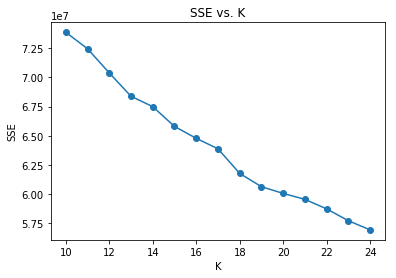

In [149]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
start_time = datetime.now()

sse = []
k_range = np.arange(10, 25)

for k in k_range:
    kmeans = KMeans(k).fit(azdias_pca)
    sse.append(np.abs(kmeans.score(azdias_pca)))
    
plt.plot(k_range, sse, linestyle='-', marker='o');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

print(f"--- Run time: {datetime.now() - start_time}---")

--- Run time: 0:27:57.681110---


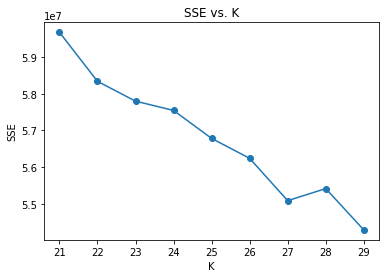

In [150]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Try it again with more clusters
start_time = datetime.now()

sse = []
k_range = np.arange(21, 30)

for k in k_range:
    kmeans = KMeans(k).fit(azdias_pca)
    sse.append(np.abs(kmeans.score(azdias_pca)))
    
plt.plot(k_range, sse, linestyle='-', marker='o');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

print(f"--- Run time: {datetime.now() - start_time}---")

In [151]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

start_time = datetime.now()

kmeans = KMeans(25).fit(azdias_pca)

kmeans_labels = kmeans.predict(azdias_pca)

print(f"--- Run time: {datetime.now() - start_time}---")

--- Run time: 0:03:19.060469---


### Discussion 3.1: Apply Clustering to General Population

We see a good drop from 25 to 27 and will take 25 as the max clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [152]:
# Load in the customer demographics data.

# We already have a cleaned version of customer data from previous section "customer_cleaned"

customer_scaled = scaler.fit_transform(customer_cleaned)

# Convert nd array to data frame
customer_scaled = pd.DataFrame(customer_scaled)
customer_scaled.columns = list(customer_cleaned)
customer_scaled.head()

/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0.701642,0.723110,-0.516974,0.516204,-0.600701,0.137715,-0.553294,-1.256422,0.894927,1.032615,...,-0.683051,-0.345276,-0.208274,1.876792,-0.1265,0.542403,-0.308575,-0.187969,-0.188913,-0.27812
1,0.701642,0.723110,-0.516974,0.516204,-0.600701,2.182391,0.965676,0.048321,0.894927,-1.437966,...,-0.683051,-0.345276,-0.208274,-0.532824,-0.1265,-1.843648,-0.308575,5.320023,-0.188913,-0.27812
2,0.701642,0.723110,-0.516974,0.516204,0.397009,-0.884622,-0.553294,0.048321,-0.795291,1.032615,...,-0.683051,-0.345276,-0.208274,1.876792,-0.1265,0.542403,-0.308575,-0.187969,-0.188913,-0.27812
3,-0.669061,-1.241857,-0.516974,-0.665548,2.392427,3.204728,-0.553294,1.353064,0.894927,-0.202675,...,1.464020,-0.345276,-0.208274,-0.532824,-0.1265,-1.843648,3.240702,-0.187969,-0.188913,-0.27812
4,-0.669061,0.723110,-0.516974,0.516204,-0.600701,0.137715,0.206191,1.353064,-0.795291,1.032615,...,-0.683051,-0.345276,-0.208274,-0.532824,-0.1265,0.542403,-0.308575,-0.187969,-0.188913,-0.27812


In [153]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_pca = pca.transform(customer_scaled)
customer_clusters = kmeans.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


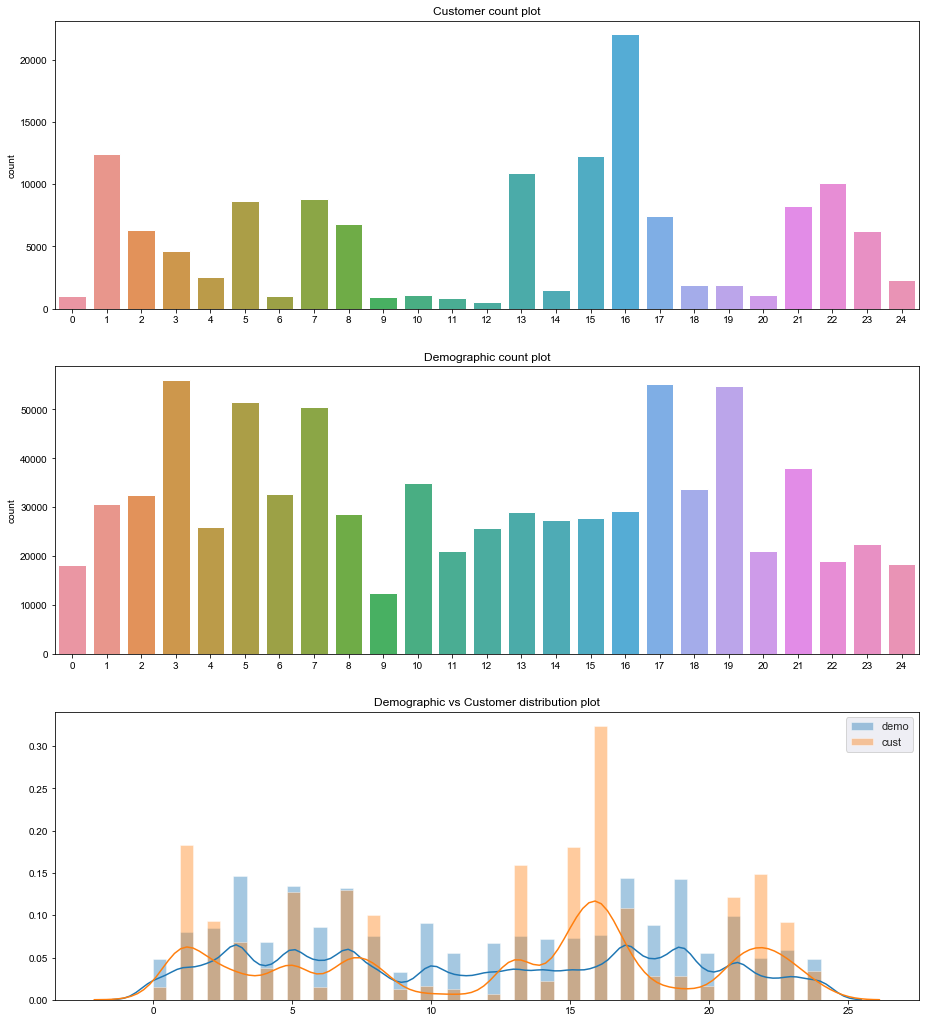

In [154]:
fig = plt.figure()
ax=fig.add_axes([0,0,2,1], title='Demographic vs Customer distribution plot')
ax2=fig.add_axes([0,1.2,2,1], title='Demographic count plot')
ax3=fig.add_axes([0,2.4,2,1], title='Customer count plot')
sns.set(style="darkgrid")
sns.distplot(kmeans_labels, label='demo',ax=ax)
sns.distplot(customer_clusters, label='cust', ax=ax)
sns.countplot(kmeans_labels, label='demo', ax=ax2)
sns.countplot(customer_clusters, label='cust', ax=ax3)
ax.legend();

In [155]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
cust_df = pd.DataFrame(customer_clusters,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(customer_clusters)*100
pop_df = pd.DataFrame(kmeans_labels,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(kmeans_labels)*100
diff = (cust_df-pop_df)
diff.rename_axis({'index':'DiffPerc'}, axis=1, inplace=True)
cust_df.rename_axis({'index':'CustPerc'}, axis=1, inplace=True)
pop_df.rename_axis({'index':'PopPerc'}, axis=1, inplace=True)
diff = diff.join(cust_df).join(pop_df).sort_values('DiffPerc',ascending=False)
diff.fillna(0, inplace=True)
diff

/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  
/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  import sys
/Users/ravimalhotra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  


,DiffPerc,CustPerc,PopPerc
Cluster,,,
16,11.907850,15.575825,3.667975
15,5.170733,8.665787,3.495053
1,4.931663,8.771682,3.840019
22,4.732026,7.127477,2.395451
13,4.043106,7.676722,3.633616
23,1.617254,4.427140,2.809886
8,1.223649,4.821778,3.598129
21,1.057379,5.819314,4.761935
2,0.369002,4.454673,4.085671


In [156]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Exmaple like in 2, 13, 16 , 22 cluster numbers

# people of 40 to 60 years and low income 

# Cluster center specs:
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=azdias_cleaned.columns)
cluster_specs

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,2.811015,3.173346,2.323990,3.838099,2.549317,2.735245,3.453537,2.089089,3.464742,4.635651,...,0.310853,0.046698,0.084578,0.203633,-0.003239,0.680487,0.107148,0.064454,0.012940,0.129969
1,3.961988,5.465782,0.803311,5.133574,1.283963,1.197825,1.681490,1.820197,4.046952,4.033608,...,0.155072,0.041742,0.018234,0.559715,0.042837,1.038073,0.042125,-0.006950,-0.059041,0.017407
2,3.983842,4.218333,0.794818,5.223849,0.841530,1.085617,3.713120,1.865554,4.613800,4.247108,...,0.389851,0.199145,0.021282,0.107859,0.010769,0.639347,0.112136,0.065880,0.091839,0.073644
3,3.629518,3.968713,1.358025,4.800107,1.360677,1.377726,2.824656,2.418506,4.823605,4.425253,...,0.421969,0.201638,0.085627,0.019010,-0.003253,0.545454,0.065395,0.072933,0.107333,0.170061
4,3.070332,4.851054,1.776454,3.753188,1.925618,2.646549,1.044920,2.025582,3.413382,4.576819,...,0.286169,0.033838,0.063154,0.296397,0.035139,0.991074,0.023353,0.017643,-0.015864,0.000315
5,3.932874,5.329636,0.813847,5.097304,1.227040,1.311754,1.825277,1.919358,4.271972,3.992396,...,0.274010,0.028973,0.001378,0.428004,0.055590,0.986924,0.061559,-0.020852,0.007887,-0.011889
6,2.892465,3.533639,2.197248,3.694475,2.449335,2.866499,2.746300,2.094364,2.996356,4.433130,...,0.184785,0.035595,-0.001664,0.571070,0.013390,1.026638,0.040125,-0.015877,-0.019546,-0.005189
7,4.172401,4.112184,0.588928,5.424072,0.608969,0.933983,4.201758,1.510414,4.766036,4.024050,...,0.364421,0.132215,0.082169,0.070097,-0.003478,0.444506,0.183920,0.113367,0.091126,0.141376
8,3.435963,5.193352,1.423308,4.420018,1.779493,2.098212,0.984495,1.991079,3.531800,4.222071,...,0.248465,0.044458,0.012754,0.280451,0.082277,0.991952,0.054925,-0.011552,-0.003117,-0.008752
9,3.058309,5.014294,1.821833,3.630914,2.244405,2.523715,1.168808,1.929363,3.196526,4.457622,...,0.181084,0.105462,0.006130,0.466491,0.056173,1.037161,0.020748,-0.020063,-0.005219,-0.010694


In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#  Like cluster Number - 3, 6 , 10 19

# Younger age group of 30 to 40 with average income


### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster number 2, 5, 7 and 17 are very famous for customer from demography
with charcters like:- more age and low income

and 3, 6 and 10 are not very famous with customer

    


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.